In [1]:
from envs import SingleLaneEnv
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

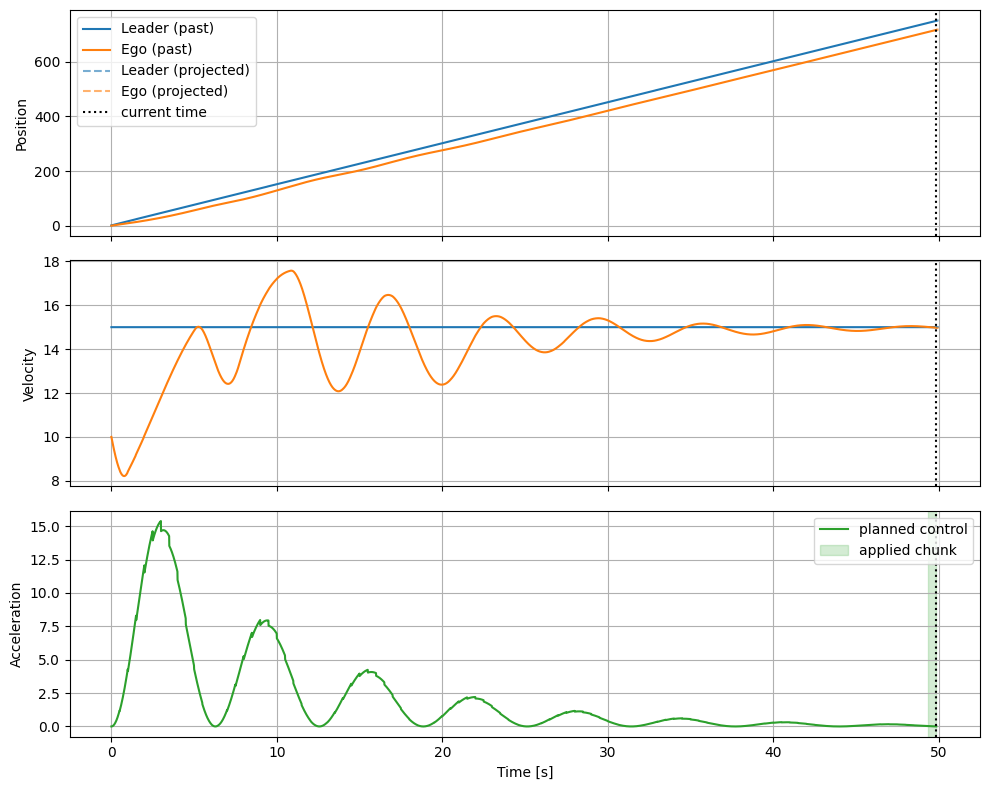

step=99 | t=49.850 | reward= 0.718 | 
Done.


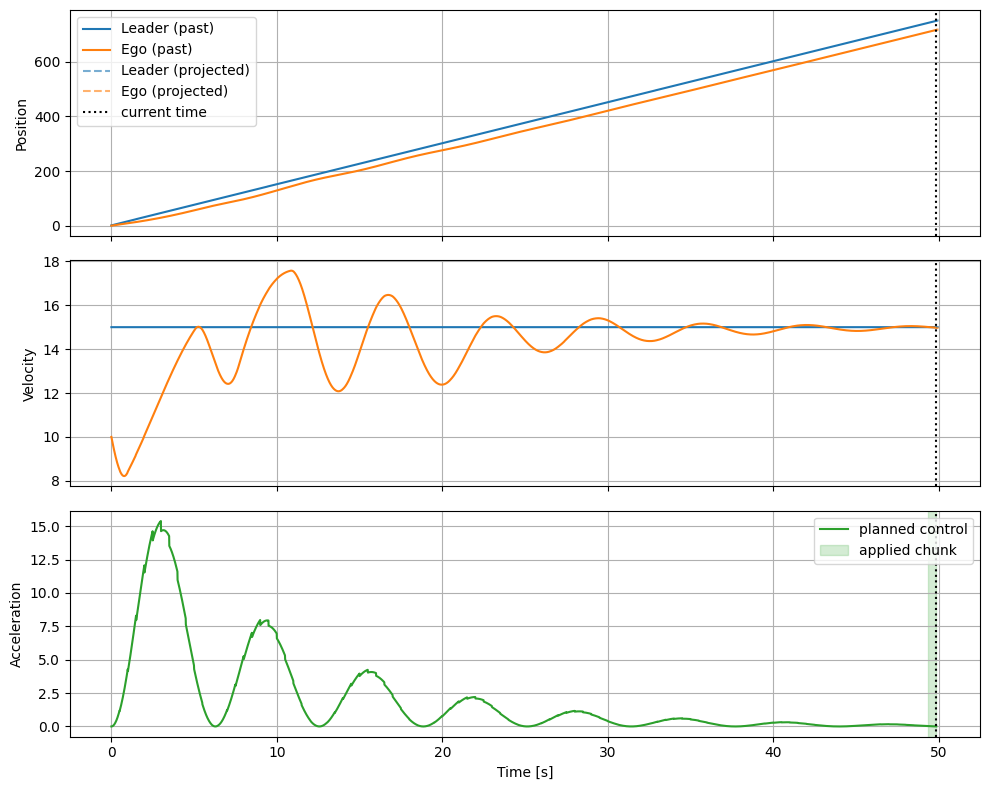

In [2]:
env = SingleLaneEnv(T=50.0, dt = 0.01, macro_dt=0.5)

obs, info = env.reset()


print("Initial observation keys:", obs.keys())
print("Trajectory shape:", obs["traj"].shape)
print("Initial t:", obs["t"])


# Rollout loop
n_steps = 100
stepsline = np.arange(env.n_total)
U = 10.0 * (-np.sin(env.dt * stepsline+np.pi/2)+1)

for step in range(n_steps):
    # Example control: small oscillating acceleration
    u = U[:]

    # Action must be a vector of length env.n_total
    action = np.full(env.n_total, u, dtype=np.float32)


    (obs, _), reward, terminated, info = env.step(action)


    # Render
    env.render(control=U)


    print(
    f"step={step:02d} | "
    f"t={obs['t']:.3f} | "
    f"reward={reward: .3f} | "
    )
    U[env.chunk_micro*(step+1):] *= 0.95


print("Done.")

## Using the action wrapper

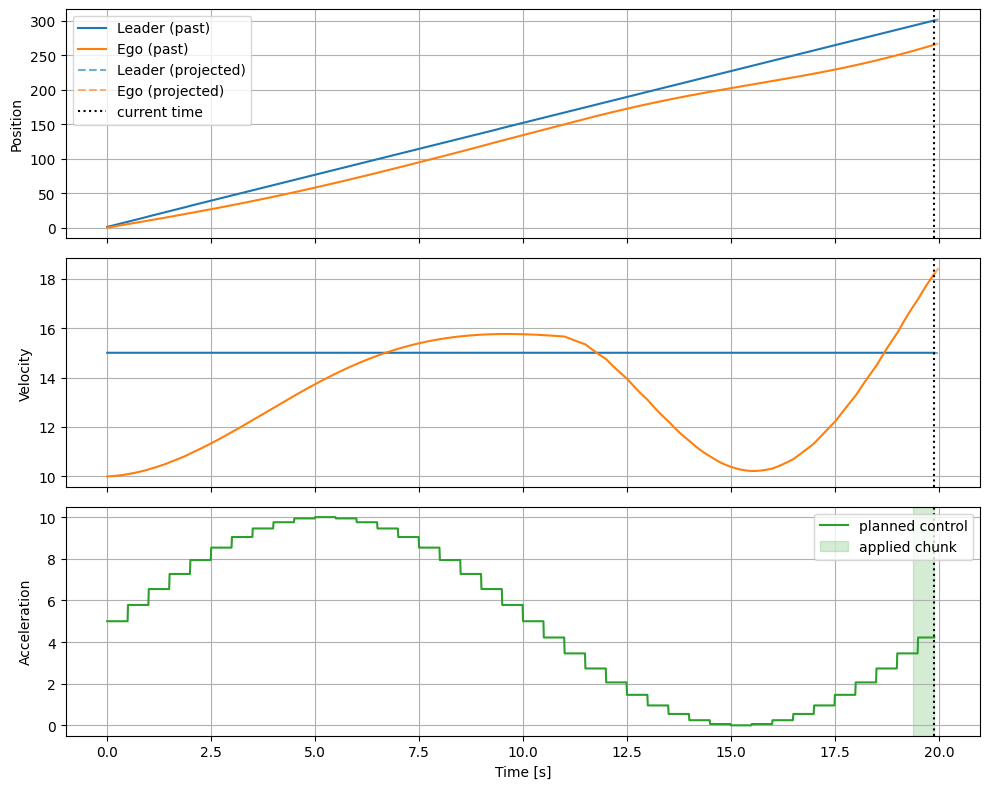

step=39 | t=19.890 | reward= 0.665 | done=False
Done.


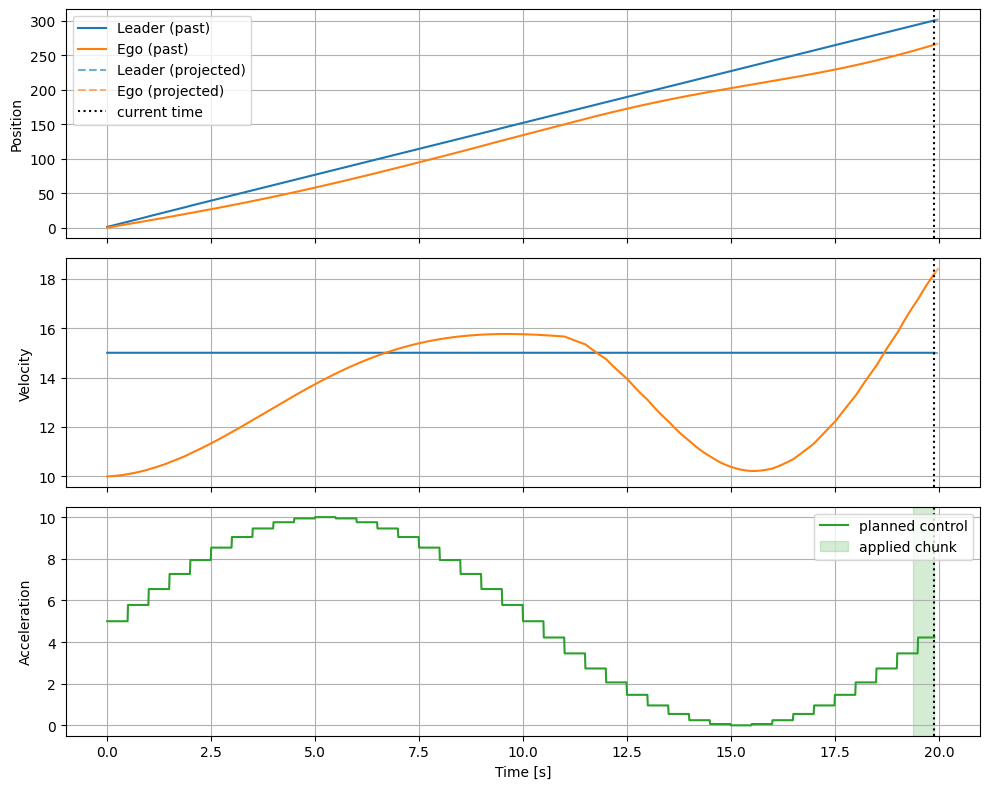

In [5]:
from envs import SingleLaneEnv, BasisActionWrapper

# --- create env + wrapper ---
base_env = SingleLaneEnv()
K = 40  # choose whatever you want (bins over [0,T])
env = BasisActionWrapper(base_env, K=K)

(obs, info) = env.reset()

print("Initial observation keys:", obs.keys())
print("Trajectory shape:", obs["traj"].shape)
print("Initial t:", obs["t"])

# Rollout loop
n_steps = 40

# Example: define a time-varying alpha plan (for testing)
# Here: alpha oscillates across bins
bins = np.arange(K)
alpha_plan = 10 * (np.sin(2 * np.pi * bins / K) + 1) / 2.0  # in [0, 1.5]

for step in range(n_steps):
    # Option A: keep same alpha each step (pure test)
    alpha = alpha_plan.astype(np.float32)

    # Option B: vary alpha over time (uncomment)
    # alpha = (1.5 * (np.sin(0.2 * step + 2 * np.pi * bins / K) + 1) / 2.0).astype(np.float32)

    # Step the WRAPPED env with alpha
    (obs, _), reward, done, info = env.step(alpha)

    # Reconstruct full-horizon control for rendering
    # env is the wrapper, base env is env.env
    U_hat = alpha @ env.Phi  # shape (n_total,)

    # Render using base env render (wrapper doesn't override render)
    env.env.render(control=U_hat)

    print(
        f"step={step:02d} | "
        f"t={obs['t']:.3f} | "
        f"reward={reward: .3f} | "
        f"done={done}"
    )

    # slow down for visualization

    if done:
        break

print("Done.")

In [1]:
print("Hello world!")

Hello world!


## PPO

In [ ]:
from envs import SingleLaneEnv, BasisActionWrapper
from PPO import PPO

# Initialize the base environment
base_env = SingleLaneEnv(T=50.0, dt = 0.01, macro_dt=0.5)

# Get the n_chunks value from the base environment
# We assume SingleLaneEnv correctly defines n_chunks
K_value = base_env.n_chunks

# Wrap the environment with BasisActionWrapper
# Pass K_value as the K parameter
wrapped_env = BasisActionWrapper(base_env, K=K_value)

# Manually add the 'n_chunks' attribute to the wrapped environment
# This ensures PPO can access it, as it seems to be looking for it
# on the wrapper itself or an object that identifies as the wrapper.
wrapped_env.n_chunks = K_value

# Now, pass the correctly configured wrapped_env to PPO
actor, critic = PPO(wrapped_env, episodes=100, log_dir="runs/ppo_singlelane")